In [207]:
import gym
from gym import spaces
import numpy as np
import os
import pandas as pd
from stable_baselines3 import PPO, DQN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from stable_baselines3.common.env_checker import check_env
from collections import deque

SLIDE_WINDOW_SIZE = 1  # size of the slide window 1 if default statefunction is chosen

def defaultState(timeseries, cursor):
  """
  :param timeseries:
  :param cursor: the position where in the TimeSeries we are currently
  :return: The Value of the current position, states with the same value are treated the same way
  """
  return np.asarray([np.float64(timeseries['value'][cursor])])

def defaultReward(timeseries, cursor, action, path=None):
  """
  :param timeseries:
  :param cursor: the position where in the TimeSeries we are currently
  :param action: the chosen action (the label we put on the state, Anomaly or Normal)
  :return: Rewards shaped inside the Config File
  """
  if action == timeseries['anomaly'][cursor]:
      return 1
  else:
      return -1

def SlideWindowStateFuc(timeseries, timeseries_cursor):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        return [timeseries['value'][i + 1]
                for i in range(timeseries_cursor - SLIDE_WINDOW_SIZE, timeseries_cursor)]
    else:
        return np.zeros(SLIDE_WINDOW_SIZE)

def SlideWindowRewardFuc(timeseries, timeseries_cursor, action, path=None):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        sum_anomaly = np.sum(timeseries['anomaly']
                             [timeseries_cursor - SLIDE_WINDOW_SIZE + 1:timeseries_cursor + 1])
        if sum_anomaly == 0:
            if action == 0:
                return 1  # 0.1      # true negative
            else:
                return -1  # 0.5     # false positive, error alarm

        if sum_anomaly > 0:
            if action == 0:
                return -1  # false negative, miss alarm
            else:
                return 1  # 10      # true positive
    else:
        return 0

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, statefunction=defaultState, rewardfunction=defaultReward, scaler = MinMaxScaler(), file="test.csv" ,dir="./series/", verbose=True):
    super(CustomEnv, self).__init__()
    self.filename = file
    self.file = os.path.join(dir + self.filename)
    self.cursor = -1
    self.cursor_init = 0
    self.statefunction = statefunction
    self.rewardfunction = rewardfunction
    self.scaler = scaler
    self.path = deque([], maxlen=SLIDE_WINDOW_SIZE)

    self.timeseries_labeled = pd.read_csv(os.path.join(dir + file), usecols=[1, 2], header=0, sep=",",
                                          names=['value', 'anomaly'],
                                          encoding="utf-8")
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Box(low=0.0, high=1.0,
                                        shape=(SLIDE_WINDOW_SIZE,), dtype=np.float32)
    if verbose:
        print(self.__str__())

  def step(self, action):
    if len(self.path) == self.path.maxlen:
        # just saving to oldest maybe useful later on
        oldest = self.path.pop()
    if len(self.path) < self.path.maxlen:
        self.path.appendleft(action)
    reward = self.rewardfunction(self.timeseries_labeled, self.cursor, action, self.path)
    state = self.statefunction(self.timeseries_labeled, self.cursor)
    self.cursor += 1
    if self.cursor >= self.timeseries_labeled['value'].size:
        done = True
    else:
        done = False
    return state, reward, done, {}

  def reset(self):
    self.cursor = self.cursor_init
    self.path.clear()
    self.normalize_timeseries()
    init_state = self.statefunction(self.timeseries_labeled, self.cursor)
    return init_state

  def render(self, mode='human'):
    pass

  def close (self):
    pass

  def __str__(self):
    """
    :return: String Representation of the TimeSeriesEnvironment Class, mainly for debug information
    """
    return "TimeSeries from: {}\n Header(labeled):\n {} \nRows:\n " \
           "{}\nMeanValue:\n {}\nMaxValue:\n {}\nMinValue:\n {}".format(
        self.filename,
        self.timeseries_labeled.head(
            3),
        self.timeseries_labeled.shape[0],
        round(self.timeseries_labeled["value"].mean(), 2),
        round(self.timeseries_labeled["value"].max(), 2),
        round(self.timeseries_labeled["value"].min(), 2))

  def normalize_timeseries(self):
    self.timeseries_labeled["value"] = self.scaler.fit_transform(self.timeseries_labeled[["value"]])

Test if environment is legit

In [208]:
env = CustomEnv()
# It will check your custom environment and output additional warnings if needed
check_env(env)


TimeSeries from: test.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0


In [209]:
# Define and Train the agent
model = PPO('MlpPolicy', env, n_steps=2048, batch_size=24, n_epochs=10, gamma=0.9,)
#model = DQN("MlpPolicy", env)
model.learn(total_timesteps=10000)

In [210]:
# Create a custom evaluator

def evaluate(model, num_episodes=1):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    # Using an Array to track all rewards over all episodes
    all_episode_rewards = []
    all_episode_actions = []
    for i in range(num_episodes):
        # testing for each episode on complete run until the environment is done
        episode_rewards = []
        episode_actions = []
        done = False
        # get the first observation out of the environment
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_actions.append(int(action))
            episode_rewards.append(reward)

        all_episode_actions.append(episode_actions)
        all_episode_rewards.append(sum(episode_rewards))
        best_episode_idx = np.argmax(all_episode_rewards)
        best_episode_actions = all_episode_actions[best_episode_idx]

    print("Maximum Reward: ", np.max(all_episode_rewards),
          "\nAverage Reward: ", np.mean(all_episode_rewards), "\n TestEpisodes: ", num_episodes)
    plot_result(model.get_env(), best_episode_actions)

def plot_result(env, actions):
    series = pd.DataFrame(env.get_attr("timeseries_labeled")[0])
    plt.figure(figsize=(15, 7))
    plt.plot(series.index , actions, label="Actions", linestyle="solid")
    plt.plot(series.index , series["anomaly"] , label="True Label", linestyle="dotted")
    plt.plot(series.index , series["value"] , label="Series", linestyle="dashed")
    plt.legend()
    plt.ylabel('Reward Sum')
    plt.show()

Maximum Reward:  1260.0 
Average Reward:  1260.0 
 TestEpisodes:  1


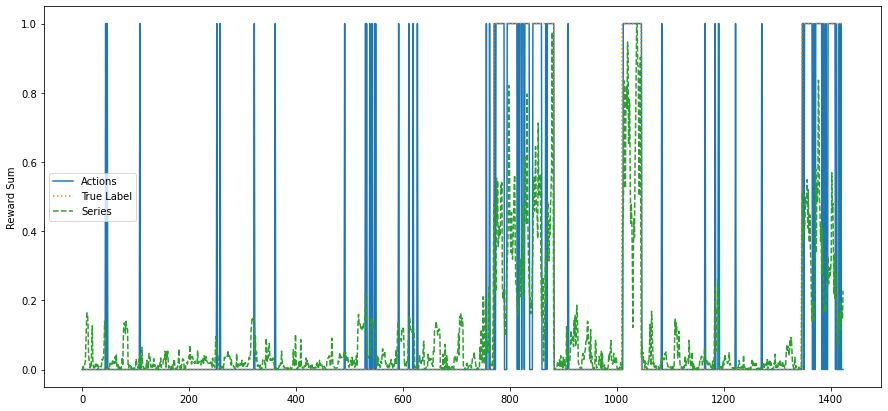

In [211]:
evaluate(model)

As we can see our agent has too few information in its state to approximate the correct value function
therefore we are trying to increase the state information by introducing a sliding window state

TimeSeries from: test.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0
Maximum Reward:  1389.0 
Average Reward:  1389.0 
 TestEpisodes:  1


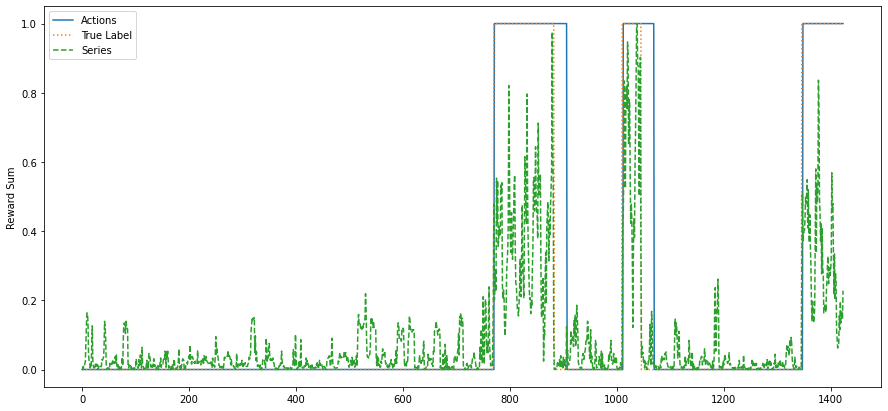

In [212]:
SLIDE_WINDOW_SIZE = 25  # size of the slide window 1 if default statefunction is chosen
env = CustomEnv(statefunction=SlideWindowStateFuc, rewardfunction=SlideWindowRewardFuc)
check_env(env)
# check the env
log = "./dqn_tensorboard/"
model = DQN("MlpPolicy", env,  learning_rate=0.001, buffer_size=50000, learning_starts=5000,
            batch_size=SLIDE_WINDOW_SIZE, tau=1.0, gamma=0.99, train_freq=4, gradient_steps=1, n_episodes_rollout=- 1,
            optimize_memory_usage=False, target_update_interval=10000, exploration_fraction=0.1,
            exploration_initial_eps=1.0, exploration_final_eps=0.0, max_grad_norm=10, tensorboard_log=None,
            create_eval_env=False,
            policy_kwargs=None, verbose=0, seed=None, device='auto', _init_setup_model=True)
model.learn(total_timesteps=10000, tb_log_name="first_run")
evaluate(model, num_episodes=1)

We can still observe the behavior, that our agent cannot detect hard cuts in falling anomalies as these
are basically not detectable with the current state representation.

Next we will try out the Binary State Function collecting all States in our Trace
